In [1]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import gc
from sklearn.metrics import r2_score

from src.model import model_fit, ensemble_predict
from src.utils import set_seed, portfolio_cumulative_return, prediction_long_short, build_portfolios

d:\software_installation\python\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# load data
X = pd.read_pickle('data/dataset.pkl')
X.set_index('year_month', inplace=True)

# define columns variables
cols = ['InvestPPEInv', 'ShareIss1Y', 'ShareRepurchase', 'DelCOA', 'dNoa', 'GrLTNOA', 'IntMom', 'LRreversal', 'Mom12m', 'Mom6m', 'MRreversal', 'ResidualMomentum', 'STreversal', 'AM', 'BMdec', 'ChEQ', 'AssetGrowth', 'ChNWC', 'DelEqu', 'NOA', 'Size', 'SP', 'AbnormalAccruals', 'Accruals', 'PctAcc', 'OPLeverage', 'BookLeverage', 'CF', 'cfp', 'DelCOL', 'DelFINL', 'IdioRisk', 'IdioVol3F', 'Leverage', 'Beta', 'BetaFP', 'BidAskSpread', 'DolVol', 'Illiquidity', 'PRC', 'VolMkt', 'VolSD', 'High52', 'MaxRet', 'CashProd', 'GP', 'roaq', 'RoE', 'DelLTI', 'P_I', 'EU_H', 'C_H', 'SO_I', 'CFNAI', 'SENT', 'pdnd', 'ripo', 'nipo', 'cefd', 's', 'sp500_divprc', 'sp500_pe', 'sp500var', 'ab_capm', 'ab_ff3', 'ab_ff5', 'ex_return']

# firm feature
firm_features = ['InvestPPEInv', 'ShareIss1Y', 'ShareRepurchase', 'DelCOA', 'dNoa', 'GrLTNOA', 'IntMom', 'LRreversal', 'Mom12m', 'Mom6m', 'MRreversal', 'ResidualMomentum', 'STreversal', 'AM', 'BMdec', 'ChEQ', 'AssetGrowth', 'ChNWC', 'DelEqu', 'NOA', 'Size', 'SP', 'AbnormalAccruals', 'Accruals', 'PctAcc', 'OPLeverage', 'BookLeverage', 'CF', 'cfp', 'DelCOL', 'DelFINL', 'IdioRisk', 'IdioVol3F', 'Leverage', 'Beta', 'BetaFP', 'BidAskSpread', 'DolVol', 'Illiquidity', 'PRC', 'VolMkt', 'VolSD', 'High52', 'MaxRet', 'CashProd', 'GP', 'roaq', 'RoE', 'DelLTI']

In [3]:
# split data
from sklearn.model_selection import train_test_split
train, X_test = train_test_split(X, test_size=1/3, shuffle=True, random_state=100)
X_train, X_val = train_test_split(train, test_size=1/2, shuffle=True, random_state=100)

In [4]:
# scale data (standerdized)
# fit scaler to train data, and apply it to validation and test data
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
X_train_scaled = scl.fit_transform(X_train[cols])
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.index = X_train.index
X_train_scaled.columns = cols

X_val_scaled = scl.transform(X_val[cols])
X_val_scaled = pd.DataFrame(X_val_scaled)
X_val_scaled.index = X_val.index
X_val_scaled.columns = cols

X_test_scaled = scl.transform(X_test[cols])
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.index = X_test.index
X_test_scaled.columns = cols

del[train, X_train, X_val, X]
gc.collect()

23

## 1. Predicting only with firm features
------


In [5]:
# ensemble fit n models
n_models = 10
model_capm_firm, model_ff3_firm, model_ff5_firm, model_ex_firm = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[firm_features], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[firm_features], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[firm_features], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[firm_features], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[firm_features], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[firm_features], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[firm_features], y=X_train_scaled['ex_return'], X_val=X_val_scaled[firm_features], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_firm.append(model_c)
    model_ff3_firm.append(model_3)
    model_ff5_firm.append(model_5)
    model_ex_firm.append(model_e)
clear_output()

In [6]:
# compute r-squared value and predictions in the test dataset
capm_yhats_firm = ensemble_predict(model_capm_firm, X_test_scaled[firm_features])
ff3_yhats_firm = ensemble_predict(model_ff3_firm, X_test_scaled[firm_features])
ff5_yhats_firm = ensemble_predict(model_ff5_firm, X_test_scaled[firm_features])
ex_yhats_firm = ensemble_predict(model_ex_firm, X_test_scaled[firm_features])

capm_r2_firm = r2_score(X_test_scaled['ab_capm'], capm_yhats_firm)
ff3_r2_firm = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_firm)
ff5_r2_firm = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_firm)
ex_r2_firm = r2_score(X_test_scaled['ex_return'], ex_yhats_firm)

clear_output()

In [7]:
# save r2 values for predicting different measures of stock returns
dt = pd.DataFrame({'Variable added': ['Firm'],
                   'Excess Return': [ex_r2_firm],
                   'CAPM abnormal returns': [capm_r2_firm],
                   'FF3 abnormal returns': [ff3_r2_firm],
                   'FF5 abnormal returns': [ff5_r2_firm]})

dt.to_csv('r2_result.csv', index=False)

### 1.1 Value weighted portfolios

In [8]:
vw_portfolio_firm = build_portfolios(capm_yhats_firm, ff3_yhats_firm, ff5_yhats_firm, ex_yhats_firm, weight='value', test_data=X_test)
vw_portfolio_cumulative_firm = portfolio_cumulative_return(data=vw_portfolio_firm)
vw_portfolio_ls_firm = prediction_long_short(data=vw_portfolio_firm)
clear_output()

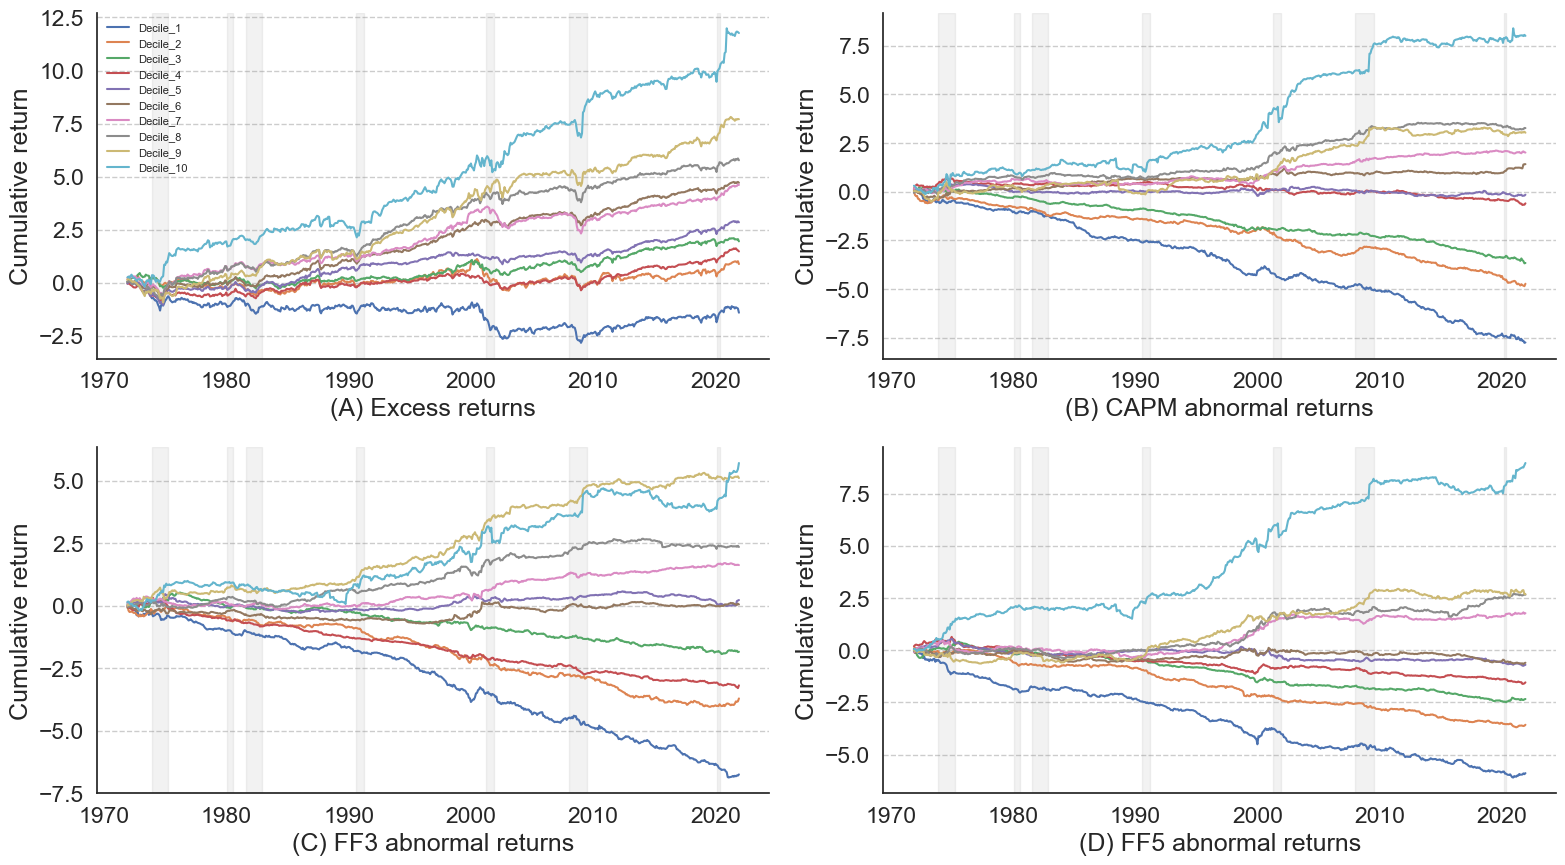

In [59]:
# plot cumulative return of value weighted portfolios
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(font_scale=1.5, style='white')
fig, axes = plt.subplots(2,2,figsize=(16,9))


sns.lineplot(data=vw_portfolio_cumulative_firm, x='year_month', y='ex_ret', hue='ex_deciles', ax=axes[0,0])
sns.lineplot(data=vw_portfolio_cumulative_firm, x='year_month', y='ab_capm', hue='capm_deciles', ax=axes[0,1])
sns.lineplot(data=vw_portfolio_cumulative_firm, x='year_month', y='ab_ff3', hue='ff3_deciles', ax=axes[1,0])
sns.lineplot(data=vw_portfolio_cumulative_firm, x='year_month', y='ab_ff5', hue='ff5_deciles', ax=axes[1,1])

returns = [['(A) Excess returns', '(B) CAPM abnormal returns'], ['(C) FF3 abnormal returns', '(D) FF5 abnormal returns']]
import matplotlib.ticker as ticker
for a in range(0, 2):
    for b in range(0, 2):
        axes[a][b].yaxis.set_major_locator(ticker.MultipleLocator(2.5))
        axes[a][b].set(xlabel=returns[a][b], ylabel='Cumulative return')
        if a == 0 and b == 0:
            # Show legend for the first panel
            handles, labels = axes[a][b].get_legend_handles_labels()
            axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
        else:
            # Hide legend for the rest of the panels
            axes[a][b].legend_.remove()
        axes[a][b].grid(axis='y', linestyle='--')
# load nber recession data
nber = pd.read_excel('data/raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

# shade recession area
for i in range(7):
 axes[0][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 axes[0][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 axes[1][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 axes[1][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
sns.despine()
plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/portfolios_firm.png', dpi=300)

## 2. Add S&P 500 Dividend Price Ratio
------


In [38]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc']
n_models = 10
model_capm_divprc, model_ff3_divprc, model_ff5_divprc, model_ex_divprc = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_divprc.append(model_c)
    model_ff3_divprc.append(model_3)
    model_ff5_divprc.append(model_5)
    model_ex_divprc.append(model_e)
clear_output()

In [39]:
# compute r-squared value and predictions in the test dataset
capm_yhats_divprc = ensemble_predict(model_capm_divprc, X_test_scaled[cols])
ff3_yhats_divprc = ensemble_predict(model_ff3_divprc, X_test_scaled[cols])
ff5_yhats_divprc = ensemble_predict(model_ff5_divprc, X_test_scaled[cols])
ex_yhats_divprc = ensemble_predict(model_ex_divprc, X_test_scaled[cols])

capm_r2_divprc = r2_score(X_test_scaled['ab_capm'], capm_yhats_divprc)
ff3_r2_divprc = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_divprc)
ff5_r2_divprc = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_divprc)
ex_r2_divprc = r2_score(X_test_scaled['ex_return'], ex_yhats_divprc)

clear_output()

In [40]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['S&P 500 DivPrc'],
                     'Excess Return': [ex_r2_divprc],
                     'CAPM abnormal returns': [capm_r2_divprc],
                     'FF3 abnormal returns': [ff3_r2_divprc],
                     'FF5 abnormal returns': [ff5_r2_divprc]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 3. Add S&P 500 PE Ratio
------


In [41]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe']
n_models = 10
model_capm_pe, model_ff3_pe, model_ff5_pe, model_ex_pe = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_pe.append(model_c)
    model_ff3_pe.append(model_3)
    model_ff5_pe.append(model_5)
    model_ex_pe.append(model_e)
clear_output()

In [42]:
# compute r-squared value and predictions in the test dataset
capm_yhats_pe = ensemble_predict(model_capm_pe, X_test_scaled[cols])
ff3_yhats_pe = ensemble_predict(model_ff3_pe, X_test_scaled[cols])
ff5_yhats_pe = ensemble_predict(model_ff5_pe, X_test_scaled[cols])
ex_yhats_pe = ensemble_predict(model_ex_pe, X_test_scaled[cols])

capm_r2_pe = r2_score(X_test_scaled['ab_capm'], capm_yhats_pe)
ff3_r2_pe = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_pe)
ff5_r2_pe = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_pe)
ex_r2_pe = r2_score(X_test_scaled['ex_return'], ex_yhats_pe)

clear_output()

In [43]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['S&P 500 PE'],
                     'Excess Return': [ex_r2_pe],
                     'CAPM abnormal returns': [capm_r2_pe],
                     'FF3 abnormal returns': [ff3_r2_pe],
                     'FF5 abnormal returns': [ff5_r2_pe]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)


## 4. Add S&P 500 Index Return Variance
------


In [24]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var']
n_models = 10
model_capm_var, model_ff3_var, model_ff5_var, model_ex_var = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_var.append(model_c)
    model_ff3_var.append(model_3)
    model_ff5_var.append(model_5)
    model_ex_var.append(model_e)
clear_output()

In [25]:
# compute r-squared value and predictions in the test dataset
capm_yhats_var = ensemble_predict(model_capm_var, X_test_scaled[cols])
ff3_yhats_var = ensemble_predict(model_ff3_var, X_test_scaled[cols])
ff5_yhats_var = ensemble_predict(model_ff5_var, X_test_scaled[cols])
ex_yhats_var = ensemble_predict(model_ex_var, X_test_scaled[cols])

capm_r2_var = r2_score(X_test_scaled['ab_capm'], capm_yhats_var)
ff3_r2_var = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_var)
ff5_r2_var = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_var)
ex_r2_var = r2_score(X_test_scaled['ex_return'], ex_yhats_var)

clear_output()

In [46]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['S&P 500 Var'],
                     'Excess Return': [ex_r2_var],
                     'CAPM abnormal returns': [capm_r2_var],
                     'FF3 abnormal returns': [ff3_r2_var],
                     'FF5 abnormal returns': [ff5_r2_var]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 5. Add P_I
------


In [47]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I']
n_models = 10
model_capm_pi, model_ff3_pi, model_ff5_pi, model_ex_pi = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_pi.append(model_c)
    model_ff3_pi.append(model_3)
    model_ff5_pi.append(model_5)
    model_ex_pi.append(model_e)
clear_output()

In [48]:
# compute r-squared value and predictions in the test dataset
capm_yhats_pi = ensemble_predict(model_capm_pi, X_test_scaled[cols])
ff3_yhats_pi = ensemble_predict(model_ff3_pi, X_test_scaled[cols])
ff5_yhats_pi = ensemble_predict(model_ff5_pi, X_test_scaled[cols])
ex_yhats_pi = ensemble_predict(model_ex_pi, X_test_scaled[cols])

capm_r2_pi = r2_score(X_test_scaled['ab_capm'], capm_yhats_pi)
ff3_r2_pi = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_pi)
ff5_r2_pi = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_pi)
ex_r2_pi = r2_score(X_test_scaled['ex_return'], ex_yhats_pi)

clear_output()

In [49]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['P_I'],
                     'Excess Return': [ex_r2_pi],
                     'CAPM abnormal returns': [capm_r2_pi],
                     'FF3 abnormal returns': [ff3_r2_pi],
                     'FF5 abnormal returns': [ff5_r2_pi]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 6. Add EU_H
------


In [50]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H']
n_models = 10
model_capm_euh, model_ff3_euh, model_ff5_euh, model_ex_euh = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_euh.append(model_c)
    model_ff3_euh.append(model_3)
    model_ff5_euh.append(model_5)
    model_ex_euh.append(model_e)
clear_output()

In [51]:
# compute r-squared value and predictions in the test dataset
capm_yhats_euh = ensemble_predict(model_capm_euh, X_test_scaled[cols])
ff3_yhats_euh = ensemble_predict(model_ff3_euh, X_test_scaled[cols])
ff5_yhats_euh = ensemble_predict(model_ff5_euh, X_test_scaled[cols])
ex_yhats_euh = ensemble_predict(model_ex_euh, X_test_scaled[cols])

from sklearn.metrics import r2_score
capm_r2_euh = r2_score(X_test_scaled['ab_capm'], capm_yhats_euh)
ff3_r2_euh = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_euh)
ff5_r2_euh = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_euh)
ex_r2_euh = r2_score(X_test_scaled['ex_return'], ex_yhats_euh)

clear_output()

In [52]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['EU_H'],
                     'Excess Return': [ex_r2_euh],
                     'CAPM abnormal returns': [capm_r2_euh],
                     'FF3 abnormal returns': [ff3_r2_euh],
                     'FF5 abnormal returns': [ff5_r2_euh]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 7. Add C_H
------


In [6]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H']
n_models = 10
model_capm_ch, model_ff3_ch, model_ff5_ch, model_ex_ch = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_ch.append(model_c)
    model_ff3_ch.append(model_3)
    model_ff5_ch.append(model_5)
    model_ex_ch.append(model_e)
clear_output()

In [7]:
# compute r-squared value and predictions in the test dataset
capm_yhats_ch = ensemble_predict(model_capm_ch, X_test_scaled[cols])
ff3_yhats_ch = ensemble_predict(model_ff3_ch, X_test_scaled[cols])
ff5_yhats_ch = ensemble_predict(model_ff5_ch, X_test_scaled[cols])
ex_yhats_ch = ensemble_predict(model_ex_ch, X_test_scaled[cols])

capm_r2_ch = r2_score(X_test_scaled['ab_capm'], capm_yhats_ch)
ff3_r2_ch = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_ch)
ff5_r2_ch = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_ch)
ex_r2_ch = r2_score(X_test_scaled['ex_return'], ex_yhats_ch)

clear_output()

In [8]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['C_H'],
                     'Excess Return': [ex_r2_ch],
                     'CAPM abnormal returns': [capm_r2_ch],
                     'FF3 abnormal returns': [ff3_r2_ch],
                     'FF5 abnormal returns': [ff5_r2_ch]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 8. Add SO_I
------


In [9]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H', 'SO_I']
n_models = 10
model_capm_soi, model_ff3_soi, model_ff5_soi, model_ex_soi = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_soi.append(model_c)
    model_ff3_soi.append(model_3)
    model_ff5_soi.append(model_5)
    model_ex_soi.append(model_e)
clear_output()

In [10]:
# compute r-squared value and predictions in the test dataset
capm_yhats_soi = ensemble_predict(model_capm_soi, X_test_scaled[cols])
ff3_yhats_soi = ensemble_predict(model_ff3_soi, X_test_scaled[cols])
ff5_yhats_soi = ensemble_predict(model_ff5_soi, X_test_scaled[cols])
ex_yhats_soi = ensemble_predict(model_ex_soi, X_test_scaled[cols])

capm_r2_soi = r2_score(X_test_scaled['ab_capm'], capm_yhats_soi)
ff3_r2_soi = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_soi)
ff5_r2_soi = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_soi)
ex_r2_soi = r2_score(X_test_scaled['ex_return'], ex_yhats_soi)

clear_output() 

In [11]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['SO_I'],
                     'Excess Return': [ex_r2_soi],
                     'CAPM abnormal returns': [capm_r2_soi],
                     'FF3 abnormal returns': [ff3_r2_soi],
                     'FF5 abnormal returns': [ff5_r2_soi]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 9. Add CFNAI
------


In [26]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H', 'SO_I', 'CFNAI']
n_models = 10
model_capm_cfnai, model_ff3_cfnai, model_ff5_cfnai, model_ex_cfnai = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_cfnai.append(model_c)
    model_ff3_cfnai.append(model_3)
    model_ff5_cfnai.append(model_5)
    model_ex_cfnai.append(model_e)
clear_output()

In [27]:
# compute r-squared value and predictions in the test dataset
capm_yhats_cfnai = ensemble_predict(model_capm_cfnai, X_test_scaled[cols])
ff3_yhats_cfnai = ensemble_predict(model_ff3_cfnai, X_test_scaled[cols])
ff5_yhats_cfnai = ensemble_predict(model_ff5_cfnai, X_test_scaled[cols])
ex_yhats_cfnai = ensemble_predict(model_ex_cfnai, X_test_scaled[cols])

capm_r2_cfnai = r2_score(X_test_scaled['ab_capm'], capm_yhats_cfnai)
ff3_r2_cfnai = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_cfnai)
ff5_r2_cfnai = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_cfnai)
ex_r2_cfnai = r2_score(X_test_scaled['ex_return'], ex_yhats_cfnai)

clear_output()

In [14]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['CFNAI'],
                     'Excess Return': [ex_r2_cfnai],
                     'CAPM abnormal returns': [capm_r2_cfnai],
                     'FF3 abnormal returns': [ff3_r2_cfnai],
                     'FF5 abnormal returns': [ff5_r2_cfnai]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 10. Add pdnd
------


In [5]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H', 'SO_I', 'CFNAI', 'pdnd']
n_models = 10
model_capm_pdnd, model_ff3_pdnd, model_ff5_pdnd, model_ex_pdnd = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_pdnd.append(model_c)
    model_ff3_pdnd.append(model_3)
    model_ff5_pdnd.append(model_5)
    model_ex_pdnd.append(model_e)
clear_output()

In [16]:
# compute r-squared value and predictions in the test dataset
capm_yhats_pdnd = ensemble_predict(model_capm_pdnd, X_test_scaled[cols])
ff3_yhats_pdnd = ensemble_predict(model_ff3_pdnd, X_test_scaled[cols])
ff5_yhats_pdnd = ensemble_predict(model_ff5_pdnd, X_test_scaled[cols])
ex_yhats_pdnd = ensemble_predict(model_ex_pdnd, X_test_scaled[cols])

capm_r2_pdnd = r2_score(X_test_scaled['ab_capm'], capm_yhats_pdnd)
ff3_r2_pdnd = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_pdnd)
ff5_r2_pdnd = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_pdnd)
ex_r2_pdnd = r2_score(X_test_scaled['ex_return'], ex_yhats_pdnd)

clear_output()

In [17]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['PDND'],
                     'Excess Return': [ex_r2_pdnd],
                     'CAPM abnormal returns': [capm_r2_pdnd],
                     'FF3 abnormal returns': [ff3_r2_pdnd],
                     'FF5 abnormal returns': [ff5_r2_pdnd]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 11. Add ripo
------


In [18]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H', 'SO_I', 'CFNAI', 'pdnd', 'ripo']
n_models = 10
model_capm_ripo, model_ff3_ripo, model_ff5_ripo, model_ex_ripo = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_ripo.append(model_c)
    model_ff3_ripo.append(model_3)
    model_ff5_ripo.append(model_5)
    model_ex_ripo.append(model_e)
clear_output()

In [19]:
# compute r-squared value and predictions in the test dataset
capm_yhats_ripo = ensemble_predict(model_capm_ripo, X_test_scaled[cols])
ff3_yhats_ripo = ensemble_predict(model_ff3_ripo, X_test_scaled[cols])
ff5_yhats_ripo = ensemble_predict(model_ff5_ripo, X_test_scaled[cols])
ex_yhats_ripo = ensemble_predict(model_ex_ripo, X_test_scaled[cols])

capm_r2_ripo = r2_score(X_test_scaled['ab_capm'], capm_yhats_ripo)
ff3_r2_ripo = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_ripo)
ff5_r2_ripo = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_ripo)
ex_r2_ripo = r2_score(X_test_scaled['ex_return'], ex_yhats_ripo)

clear_output()

In [20]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['RIPO'],
                     'Excess Return': [ex_r2_ripo],
                     'CAPM abnormal returns': [capm_r2_ripo],
                     'FF3 abnormal returns': [ff3_r2_ripo],
                     'FF5 abnormal returns': [ff5_r2_ripo]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 12. Add nipo
------


In [21]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H', 'SO_I', 'CFNAI', 'pdnd', 'ripo', 'nipo']
n_models = 10
model_capm_nipo, model_ff3_nipo, model_ff5_nipo, model_ex_nipo = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_nipo.append(model_c)
    model_ff3_nipo.append(model_3)
    model_ff5_nipo.append(model_5)
    model_ex_nipo.append(model_e)
clear_output()

In [22]:
# compute r-squared value and predictions in the test dataset
capm_yhats_nipo = ensemble_predict(model_capm_nipo, X_test_scaled[cols])
ff3_yhats_nipo = ensemble_predict(model_ff3_nipo, X_test_scaled[cols])
ff5_yhats_nipo = ensemble_predict(model_ff5_nipo, X_test_scaled[cols])
ex_yhats_nipo = ensemble_predict(model_ex_nipo, X_test_scaled[cols])

capm_r2_nipo = r2_score(X_test_scaled['ab_capm'], capm_yhats_nipo)
ff3_r2_nipo = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_nipo)
ff5_r2_nipo = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_nipo)
ex_r2_nipo = r2_score(X_test_scaled['ex_return'], ex_yhats_nipo)

clear_output()

In [23]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['NIPO'],
                     'Excess Return': [ex_r2_nipo],
                     'CAPM abnormal returns': [capm_r2_nipo],
                     'FF3 abnormal returns': [ff3_r2_nipo],
                     'FF5 abnormal returns': [ff5_r2_nipo]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 13. Add cefd
------


In [24]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H', 'SO_I', 'CFNAI', 'pdnd', 'ripo', 'nipo', 'cefd']
n_models = 10
model_capm_cefd, model_ff3_cefd, model_ff5_cefd, model_ex_cefd = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_cefd.append(model_c)
    model_ff3_cefd.append(model_3)
    model_ff5_cefd.append(model_5)
    model_ex_cefd.append(model_e)
clear_output()

In [25]:
# compute r-squared value and predictions in the test dataset
capm_yhats_cefd = ensemble_predict(model_capm_cefd, X_test_scaled[cols])
ff3_yhats_cefd = ensemble_predict(model_ff3_cefd, X_test_scaled[cols])
ff5_yhats_cefd = ensemble_predict(model_ff5_cefd, X_test_scaled[cols])
ex_yhats_cefd = ensemble_predict(model_ex_cefd, X_test_scaled[cols])

capm_r2_cefd = r2_score(X_test_scaled['ab_capm'], capm_yhats_cefd)
ff3_r2_cefd = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_cefd)
ff5_r2_cefd = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_cefd)
ex_r2_cefd = r2_score(X_test_scaled['ex_return'], ex_yhats_cefd)

clear_output()

In [26]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['CEFD'],
                     'Excess Return': [ex_r2_cefd],
                     'CAPM abnormal returns': [capm_r2_cefd],
                     'FF3 abnormal returns': [ff3_r2_cefd],
                     'FF5 abnormal returns': [ff5_r2_cefd]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 14. Add s
------


In [6]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H', 'SO_I', 'CFNAI', 'pdnd', 'ripo', 'nipo', 'cefd', 's']
n_models = 10
model_capm_s, model_ff3_s, model_ff5_s, model_ex_s = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_s.append(model_c)
    model_ff3_s.append(model_3)
    model_ff5_s.append(model_5)
    model_ex_s.append(model_e)
clear_output()

In [7]:
# compute r-squared value and predictions in the test dataset
capm_yhats_s = ensemble_predict(model_capm_s, X_test_scaled[cols])
ff3_yhats_s = ensemble_predict(model_ff3_s, X_test_scaled[cols])
ff5_yhats_s = ensemble_predict(model_ff5_s, X_test_scaled[cols])
ex_yhats_s = ensemble_predict(model_ex_s, X_test_scaled[cols])

capm_r2_s = r2_score(X_test_scaled['ab_capm'], capm_yhats_s)
ff3_r2_s = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_s)
ff5_r2_s = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_s)
ex_r2_s = r2_score(X_test_scaled['ex_return'], ex_yhats_s)

clear_output()

In [8]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['S'],
                     'Excess Return': [ex_r2_s],
                     'CAPM abnormal returns': [capm_r2_s],
                     'FF3 abnormal returns': [ff3_r2_s],
                     'FF5 abnormal returns': [ff5_r2_s]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

## 15. Add sentiment
------


In [42]:
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H', 'SO_I', 'CFNAI', 'pdnd', 'ripo', 'nipo', 'cefd', 's', 'SENT']


In [18]:
# ensemble fit n models
cols = firm_features + ['sp500_divprc', 'sp500_pe', 'sp500var', 'P_I', 'EU_H', 'C_H', 'SO_I', 'CFNAI', 'pdnd', 'ripo', 'nipo', 'cefd', 's', 'SENT']
n_models = 10
model_capm_SENT, model_ff3_SENT, model_ff5_SENT, model_ex_SENT = list(), list(), list(), list()
for i in range(0, n_models):
    # set seed for reproducibility
    set_seed(100 + i)
    # fit model with capm abnormal stock return
    model_c = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_capm'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_capm'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with ff3 abnormal stock return
    model_3 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff3'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff3'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with capm abnormal stock return
    model_5 = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ab_ff5'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ab_ff5'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    # fit model with excess stock return
    model_e = model_fit(X=X_train_scaled[cols], y=X_train_scaled['ex_return'], X_val=X_val_scaled[cols], y_val=X_val_scaled['ex_return'], penalty=0.001, learning_rate=0.01, decay_rate=0.001, momentum=0.99, batch_size=5000)
    
    # save models
    model_capm_SENT.append(model_c)
    model_ff3_SENT.append(model_3)
    model_ff5_SENT.append(model_5)
    model_ex_SENT.append(model_e)
clear_output()

In [19]:
# compute r-squared value and predictions in the test dataset
capm_yhats_SENT = ensemble_predict(model_capm_SENT, X_test_scaled[cols])
ff3_yhats_SENT = ensemble_predict(model_ff3_SENT, X_test_scaled[cols])
ff5_yhats_SENT = ensemble_predict(model_ff5_SENT, X_test_scaled[cols])
ex_yhats_SENT = ensemble_predict(model_ex_SENT, X_test_scaled[cols])

capm_r2_SENT = r2_score(X_test_scaled['ab_capm'], capm_yhats_SENT)
ff3_r2_SENT = r2_score(X_test_scaled['ab_ff3'], ff3_yhats_SENT)
ff5_r2_SENT = r2_score(X_test_scaled['ab_ff5'], ff5_yhats_SENT)
ex_r2_SENT = r2_score(X_test_scaled['ex_return'], ex_yhats_SENT)

clear_output()

In [20]:
# save r2 values for predicting different measures of stock returns
temp = pd.DataFrame({'Variable added': ['SENT'],
                     'Excess Return': [ex_r2_SENT],
                     'CAPM abnormal returns': [capm_r2_SENT],
                     'FF3 abnormal returns': [ff3_r2_SENT],
                     'FF5 abnormal returns': [ff5_r2_SENT]})

r2_result = pd.read_csv('r2_result.csv')

r2_result = pd.concat([r2_result, temp], axis=0)
r2_result.to_csv('r2_result.csv', index=False)

### 15.1 Value weighted portfolios

In [21]:
vw_portfolio_SENT = build_portfolios(capm_yhats_SENT, ff3_yhats_SENT, ff5_yhats_SENT, ex_yhats_SENT, weight='value', test_data=X_test)
vw_portfolio_cumulative_SENT = portfolio_cumulative_return(data=vw_portfolio_SENT)
vw_portfolio_ls_SENT = prediction_long_short(data=vw_portfolio_SENT)
clear_output()


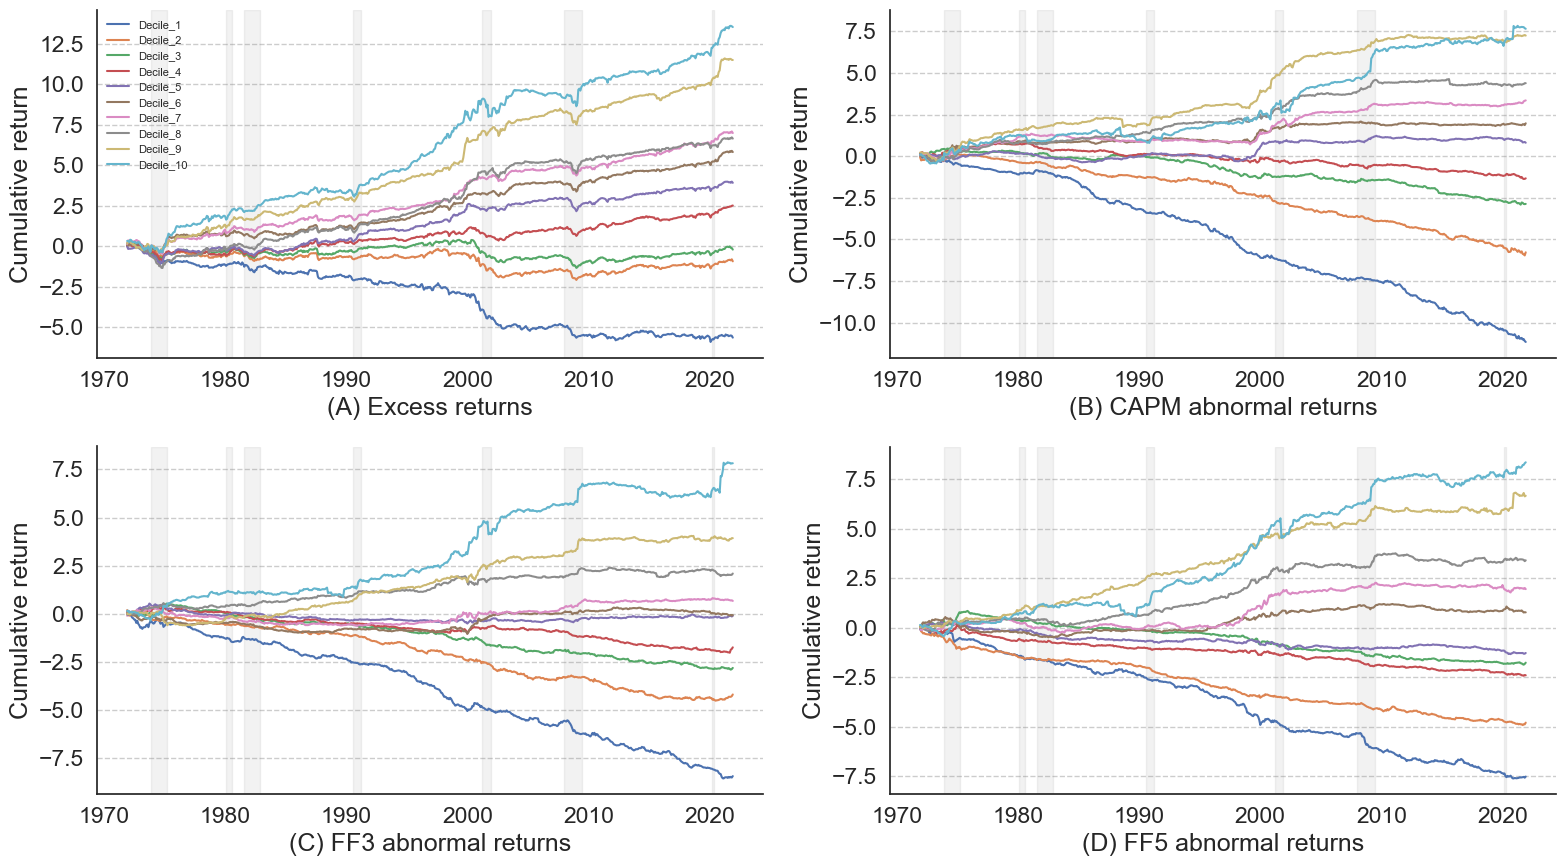

In [57]:
# plot cumulative return of value weighted portfolios
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(font_scale=1.5, style='white')
fig, axes = plt.subplots(2,2,figsize=(16,9))


sns.lineplot(data=vw_portfolio_cumulative_SENT, x='year_month', y='ex_ret', hue='ex_deciles', ax=axes[0,0])
sns.lineplot(data=vw_portfolio_cumulative_SENT, x='year_month', y='ab_capm', hue='capm_deciles', ax=axes[0,1])
sns.lineplot(data=vw_portfolio_cumulative_SENT, x='year_month', y='ab_ff3', hue='ff3_deciles', ax=axes[1,0])
sns.lineplot(data=vw_portfolio_cumulative_SENT, x='year_month', y='ab_ff5', hue='ff5_deciles', ax=axes[1,1])

returns = [['(A) Excess returns', '(B) CAPM abnormal returns'], ['(C) FF3 abnormal returns', '(D) FF5 abnormal returns']]
import matplotlib.ticker as ticker
for a in range(0, 2):
    for b in range(0, 2):
        axes[a][b].yaxis.set_major_locator(ticker.MultipleLocator(2.5))
        axes[a][b].set(xlabel=returns[a][b], ylabel='Cumulative return')
        if a == 0 and b == 0:
            # Show legend for the first panel
            handles, labels = axes[a][b].get_legend_handles_labels()
            axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
        else:
            # Hide legend for the rest of the panels
            axes[a][b].legend_.remove()
        axes[a][b].grid(axis='y', linestyle='--')
# load nber recession data
nber = pd.read_excel('data/raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

# shade recession area
for i in range(7):
 axes[0][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 axes[0][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 axes[1][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 axes[1][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
sns.despine()
plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/portfolios_sent.png', dpi=300)

In [63]:
dt = pd.read_csv('r2_result.csv')

In [64]:
dt.iloc[:, 1:5] = dt.iloc[:, 1:5].multiply(100)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


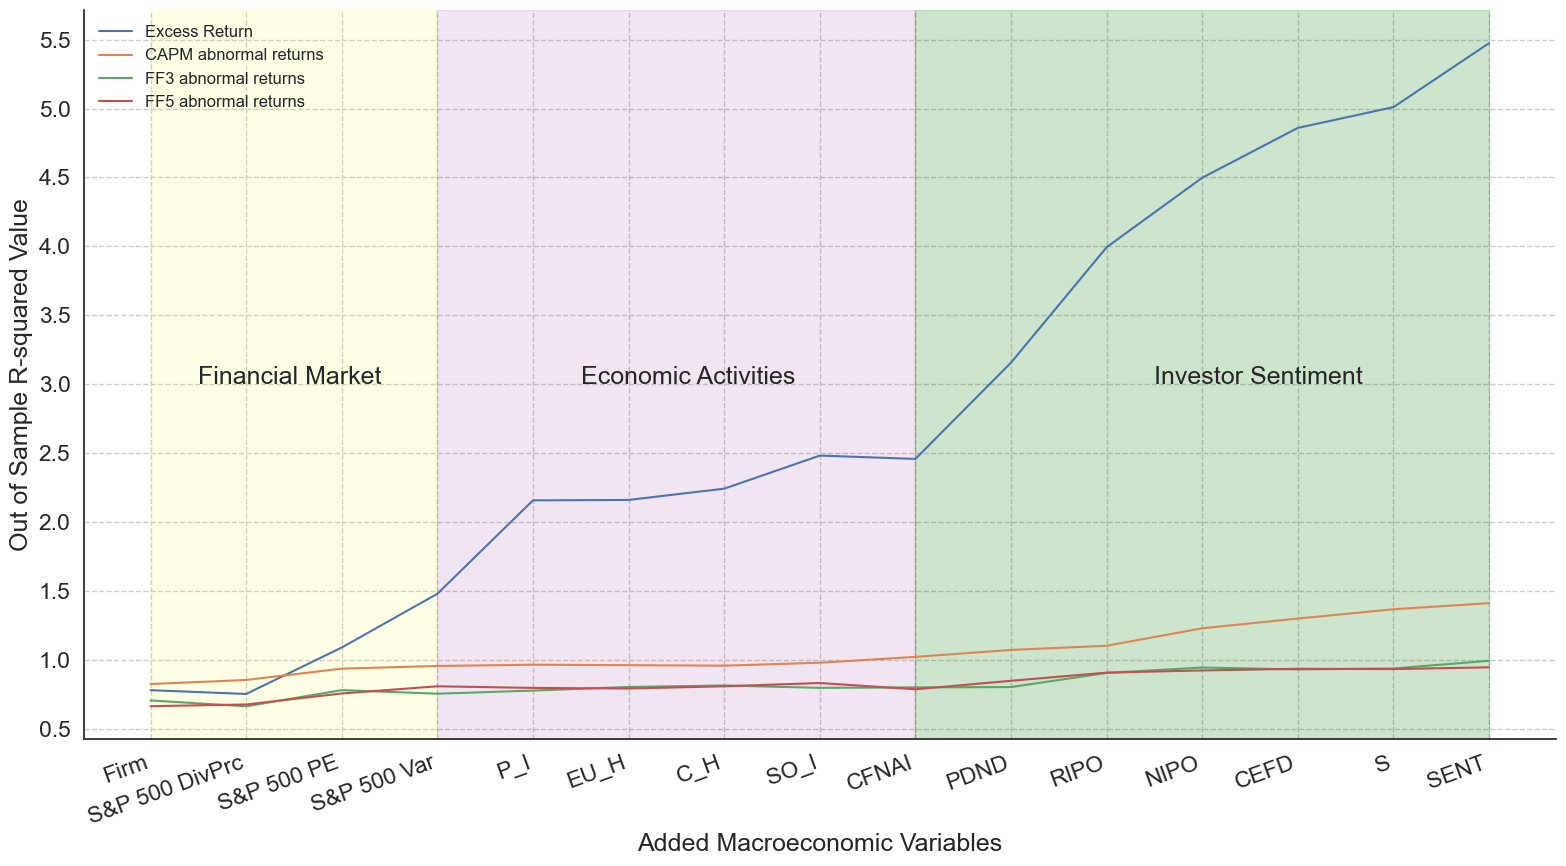

In [66]:
import matplotlib.ticker as ticker
sns.set_theme(font_scale=1.5, style='white')
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
temp = dt.melt(id_vars='Variable added')
sns.lineplot(data=temp, x='Variable added', y='value', hue='variable')

ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
ax.set(xlabel='Added Macroeconomic Variables', ylabel='Out of Sample R-squared Value')

# Set the y-tick interval to 0.003
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='12')
ax.grid(True, linestyle='--')

ax.axvspan(temp['Variable added'][0], temp['Variable added'][3], alpha=0.1, color='yellow')
ax.axvspan(temp['Variable added'][3], temp['Variable added'][8], alpha=0.1, color='purple')
ax.axvspan(temp['Variable added'][8], temp['Variable added'][14], alpha=0.2, color='green')

ax.annotate('Financial Market', (0.5, 3))
ax.annotate('Economic Activities', (4.5, 3))
ax.annotate('Investor Sentiment', (10.5, 3))

sns.despine()

plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/r2_values.png', dpi=300)

## 16. Long short portfolios 

In [28]:
# equal weighted portfolios based on prediction with only firm characteristic variables
ew_portfolio_firm = build_portfolios(capm_yhats_firm, ff3_yhats_firm, ff5_yhats_firm, ex_yhats_firm, weight='equal', test_data=X_test)
ew_portfolio_cumulative_firm = portfolio_cumulative_return(data=ew_portfolio_firm)
ew_portfolio_ls_firm = prediction_long_short(data=ew_portfolio_firm)

# equal weighted portfolios based on prediction with macroeconomic variables from financial market
ew_portfolio_var = build_portfolios(capm_yhats_var, ff3_yhats_var, ff5_yhats_var, ex_yhats_var, weight='equal', test_data=X_test)
ew_portfolio_cumulative_var = portfolio_cumulative_return(data=ew_portfolio_var)
ew_portfolio_ls_var = prediction_long_short(data=ew_portfolio_var)

# equal weighted portfolios based on prediction with macroeconomic variables from financial market + economic activities
ew_portfolio_cfnai = build_portfolios(capm_yhats_cfnai, ff3_yhats_cfnai, ff5_yhats_cfnai, ex_yhats_cfnai, weight='equal', test_data=X_test)
ew_portfolio_cumulative_cfnai = portfolio_cumulative_return(data=ew_portfolio_cfnai)
ew_portfolio_ls_cfnai = prediction_long_short(data=ew_portfolio_cfnai)

# equal weighted portfolios based on prediction with macroeconomic variables from financial market + economic activities + investor sentiment
ew_portfolio_SENT = build_portfolios(capm_yhats_SENT, ff3_yhats_SENT, ff5_yhats_SENT, ex_yhats_SENT, weight='equal', test_data=X_test)
ew_portfolio_cumulative_SENT = portfolio_cumulative_return(data=ew_portfolio_SENT)
ew_portfolio_ls_SENT = prediction_long_short(data=ew_portfolio_SENT)

d:\download\20230302_ML_paper - 副本\20230302_ML_paper - 鍓湰\src\utils.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolios_[['year_month', 'capm_deciles', 'ab_capm']] = df.groupby(['year_month', 'capm_deciles'])['ab_capm'].mean().reset_index()
d:\download\20230302_ML_paper - 副本\20230302_ML_paper - 鍓湰\src\utils.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolios_[['year_month', 'ff3_deciles', 'ab_ff3']] = df.groupby(['year_month', 'ff3_deciles'])['ab_ff3'].mean().reset_index()
d:\download\20230302_ML_paper - 副本\20230302_ML_paper - 鍓湰\src\utils.py:32: FutureWarning: The default of observ

In [29]:
# compare long-short portfolios based on model prediction (equal weighted)
ab_capm_ls = pd.DataFrame()
ab_capm_ls['Firm Features'] = ew_portfolio_ls_firm['ab_capm']
ab_capm_ls['Firm + Fin Mkt'] = ew_portfolio_ls_var['ab_capm']
ab_capm_ls['Firm + Fin Mkt + RealEco'] = ew_portfolio_ls_cfnai['ab_capm']
ab_capm_ls['Firm + Fin Mkt + RealEco + Sent'] = ew_portfolio_ls_SENT['ab_capm']

ab_ff3_ls = pd.DataFrame()
ab_ff3_ls['Firm Features'] = ew_portfolio_ls_firm['ab_ff3']
ab_ff3_ls['Firm + Fin Mkt'] = ew_portfolio_ls_var['ab_ff3']
ab_ff3_ls['Firm + Fin Mkt + RealEco'] = ew_portfolio_ls_cfnai['ab_ff3']
ab_ff3_ls['Firm + Fin Mkt + RealEco + Sent'] = ew_portfolio_ls_SENT['ab_ff3']

ab_ff5_ls = pd.DataFrame()
ab_ff5_ls['Firm Features'] = ew_portfolio_ls_firm['ab_ff5']
ab_ff5_ls['Firm + Fin Mkt'] = ew_portfolio_ls_var['ab_ff5']
ab_ff5_ls['Firm + Fin Mkt + RealEco'] = ew_portfolio_ls_cfnai['ab_ff5']
ab_ff5_ls['Firm + Fin Mkt + RealEco + Sent'] = ew_portfolio_ls_SENT['ab_ff5']

ex_ret_ls = pd.DataFrame()
ex_ret_ls['Firm Features'] = ew_portfolio_ls_firm['ex_ret']
ex_ret_ls['Firm + Fin Mkt'] = ew_portfolio_ls_var['ex_ret']
ex_ret_ls['Firm + Fin Mkt + RealEco'] = ew_portfolio_ls_cfnai['ex_ret']
ex_ret_ls['Firm + Fin Mkt + RealEco + Sent'] = ew_portfolio_ls_SENT['ex_ret']


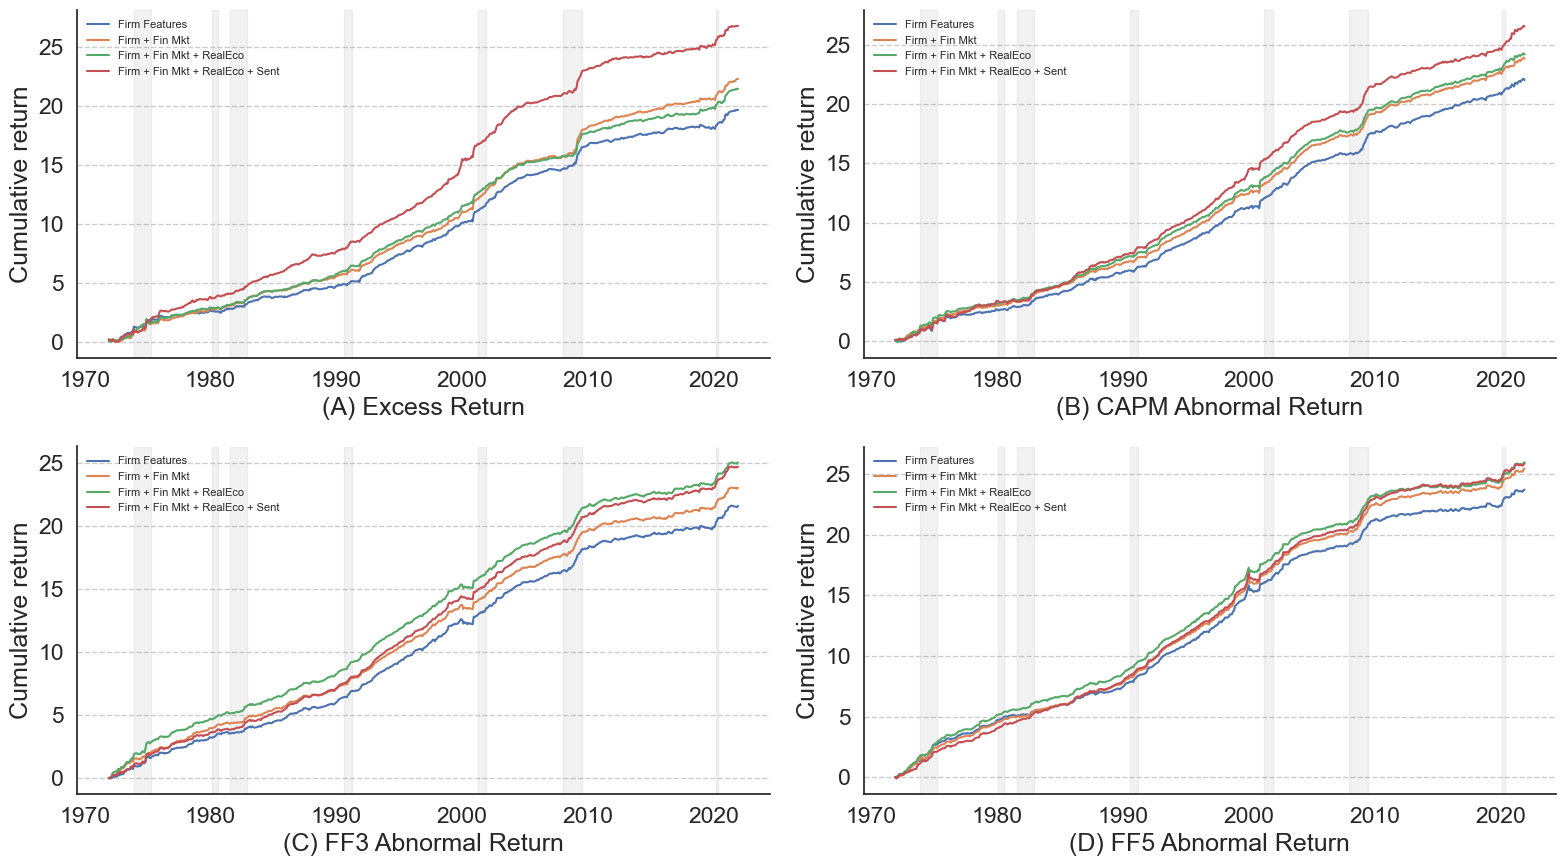

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(font_scale=1.5, style='white')
fig, axes = plt.subplots(2,2,figsize=(16,9))


tidy1 = ex_ret_ls.cumsum().reset_index().melt(id_vars='year_month')
tidy2 = ab_capm_ls.cumsum().reset_index().melt(id_vars='year_month')
tidy3 = ab_ff3_ls.cumsum().reset_index().melt(id_vars='year_month')
tidy4 = ab_ff5_ls.cumsum().reset_index().melt(id_vars='year_month')

tidy = [[tidy1, tidy2], [tidy3, tidy4]]
xlabel = [['(A) Excess Return', '(B) CAPM Abnormal Return'],
          ['(C) FF3 Abnormal Return', '(D) FF5 Abnormal Return']]
for a in range(0,2):
  for b in range(0,2):
    sns.lineplot(data=tidy[a][b], x='year_month', y='value', hue='variable', ax=axes[a][b])
    axes[a][b].set(xlabel=xlabel[a][b], ylabel='Cumulative return')
    # hide legend title
    handles, labels = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(handles=handles[0:], labels=labels[0:], loc='upper left', frameon=False, fontsize='8')
    axes[a][b].grid(axis='y', linestyle='--')
# load nber recession data
nber = pd.read_excel('data/raw_data/NBER_recession.xlsx')
nber['Peak'] = pd.PeriodIndex(nber.Peak, freq='M')
nber['Trough'] = pd.PeriodIndex(nber[' Trough'], freq='M')

# shade recession area
for i in range(7):
 axes[0][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 axes[0][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 axes[1][0].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
 axes[1][1].axvspan(nber['Peak'][i], nber['Trough'][i], alpha=0.1, color='grey')
sns.despine()
plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/ml_lo.png', dpi=300)

## 17. Feature Importance


### 17.1 Features importance of predicting excess return

In [43]:
# Features importance of predicting stock abnormal return 
import shap
# print the JS visualization code to the notebook
shap.initjs()

# set seed for reproducibility
np.random.seed(42)

# randomly draw 100 observations to compute feature importance
background = X_train_scaled.iloc[np.random.choice(X_train_scaled.shape[0], 100, replace=False)][cols]
# based on which importance is checked
X_importance = X_test_scaled.iloc[np.random.choice(X_test_scaled.shape[0], 100, replace=False)][cols]

explainer_ex = [shap.KernelExplainer(model, background) for model in model_ex_SENT]
shap_values_ex = [explain.shap_values(X_importance, nsamples=100) for explain in explainer_ex]
shap_values_ex = np.array(shap_values_ex)
# take average across ensemble members
shap_values_ex = np.mean(shap_values_ex, axis=0)
clear_output()


In [44]:
# get shap feature importance
shap_ex = np.abs(shap_values_ex)[0].mean(axis=0)
importance_ex = pd.DataFrame([cols, shap_ex.tolist()]).T
importance_ex.columns = ['column_name', 'shap_importance']
importance_ex = importance_ex.sort_values('shap_importance', ascending=False)

# load variable group data
variable_group = pd.read_excel('data/raw_data/variable_group.xlsx')
importance_ex = importance_ex.merge(variable_group, left_on='column_name', right_on='Variable', how='left')


In [45]:
# compute group importance
group_ex = importance_ex.groupby('Group')['shap_importance'].sum()
group_ex.sort_values(ascending=False, inplace=True)

The palette list has more values (9) than needed (6), which may not be intended.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



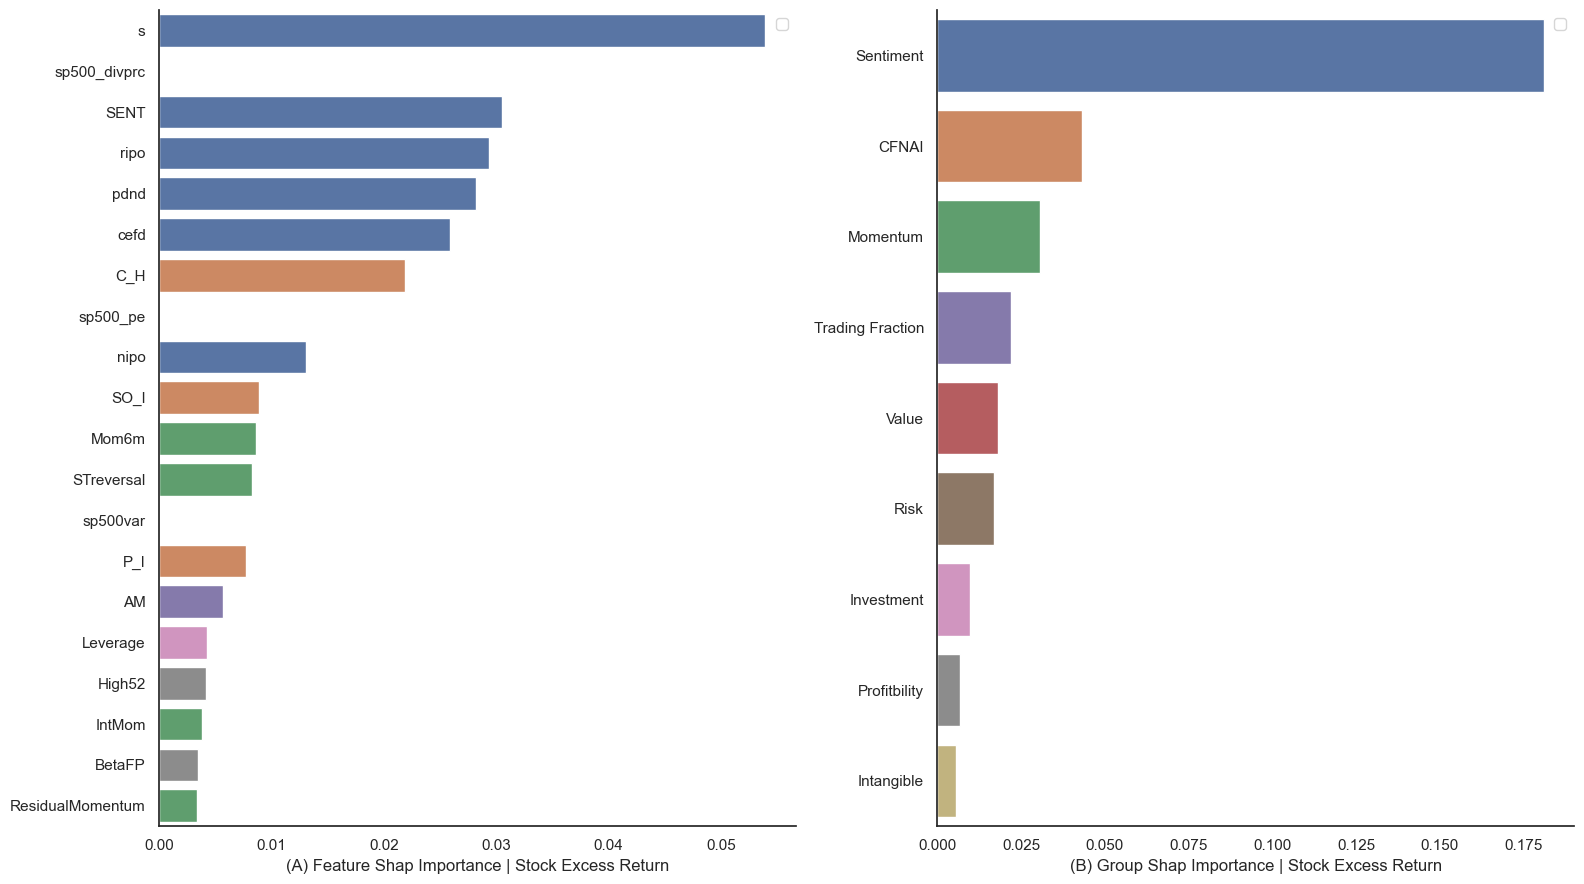

In [49]:
# plot feature importance
import seaborn as sns
from matplotlib import pyplot

sns.set_theme(font_scale=1, style='white')
fig, axes = pyplot.subplots(1,2,figsize=(16,9))

palette_1 = ['#4c72b0', '#dd8452', '#55a868', '#8172b3', '#da8bc3', '#8c8c8c', '#937860', '#c44e52', '#ccb974']
sns.barplot(data = importance_ex[0:20], x='shap_importance', y='column_name', hue='Group', dodge=False, ax=axes[0], palette=palette_1)
palette_2 = ['#4c72b0', '#dd8452', '#55a868', '#8172b3', '#c44e52', '#937860', '#da8bc3', '#8c8c8c', '#ccb974']
sns.barplot(x=group_ex[0:9], y=group_ex[0:9].index, orient='h', ax=axes[1], palette=palette_2)

for ax in axes:
  ax.set_ylabel('')
  ax.legend('')
axes[0].set_xlabel('(A) Feature Shap Importance | Stock Excess Return')
axes[1].set_xlabel('(B) Group Shap Importance | Stock Excess Return')
sns.despine(fig)

plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/feature_im1.png', dpi=300)

### 17.2 Features importance of predicting CAPM abnormal return

In [50]:
# Features importance of predicting stock abnormal return 
import shap
# print the JS visualization code to the notebook
shap.initjs()

# set seed for reproducibility
np.random.seed(42)

# randomly draw 100 observations to compute feature importance
background = X_train_scaled.iloc[np.random.choice(X_train_scaled.shape[0], 100, replace=False)][cols]
# based on which importance is checked
X_importance = X_test_scaled.iloc[np.random.choice(X_test_scaled.shape[0], 100, replace=False)][cols]

explainer_capm = [shap.KernelExplainer(model, background) for model in model_capm_SENT]
shap_values_capm = [explain.shap_values(X_importance, nsamples=100) for explain in explainer_capm]
shap_values_capm = np.array(shap_values_capm)
# take average across ensemble members
shap_values_capm = np.mean(shap_values_capm, axis=0)
clear_output()


In [51]:
# get shap feature importance
shap_capm = np.abs(shap_values_capm)[0].mean(axis=0)
importance_capm = pd.DataFrame([cols, shap_capm.tolist()]).T
importance_capm.columns = ['column_name', 'shap_importance']
importance_capm = importance_capm.sort_values('shap_importance', ascending=False)

# load variable group data
variable_group = pd.read_excel('data/raw_data/variable_group.xlsx')
importance_capm = importance_capm.merge(variable_group, left_on='column_name', right_on='Variable', how='left')


In [52]:
# compute group importance
group_capm = importance_capm.groupby('Group')['shap_importance'].sum()
group_capm.sort_values(ascending=False, inplace=True)

The palette list has more values (9) than needed (5), which may not be intended.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



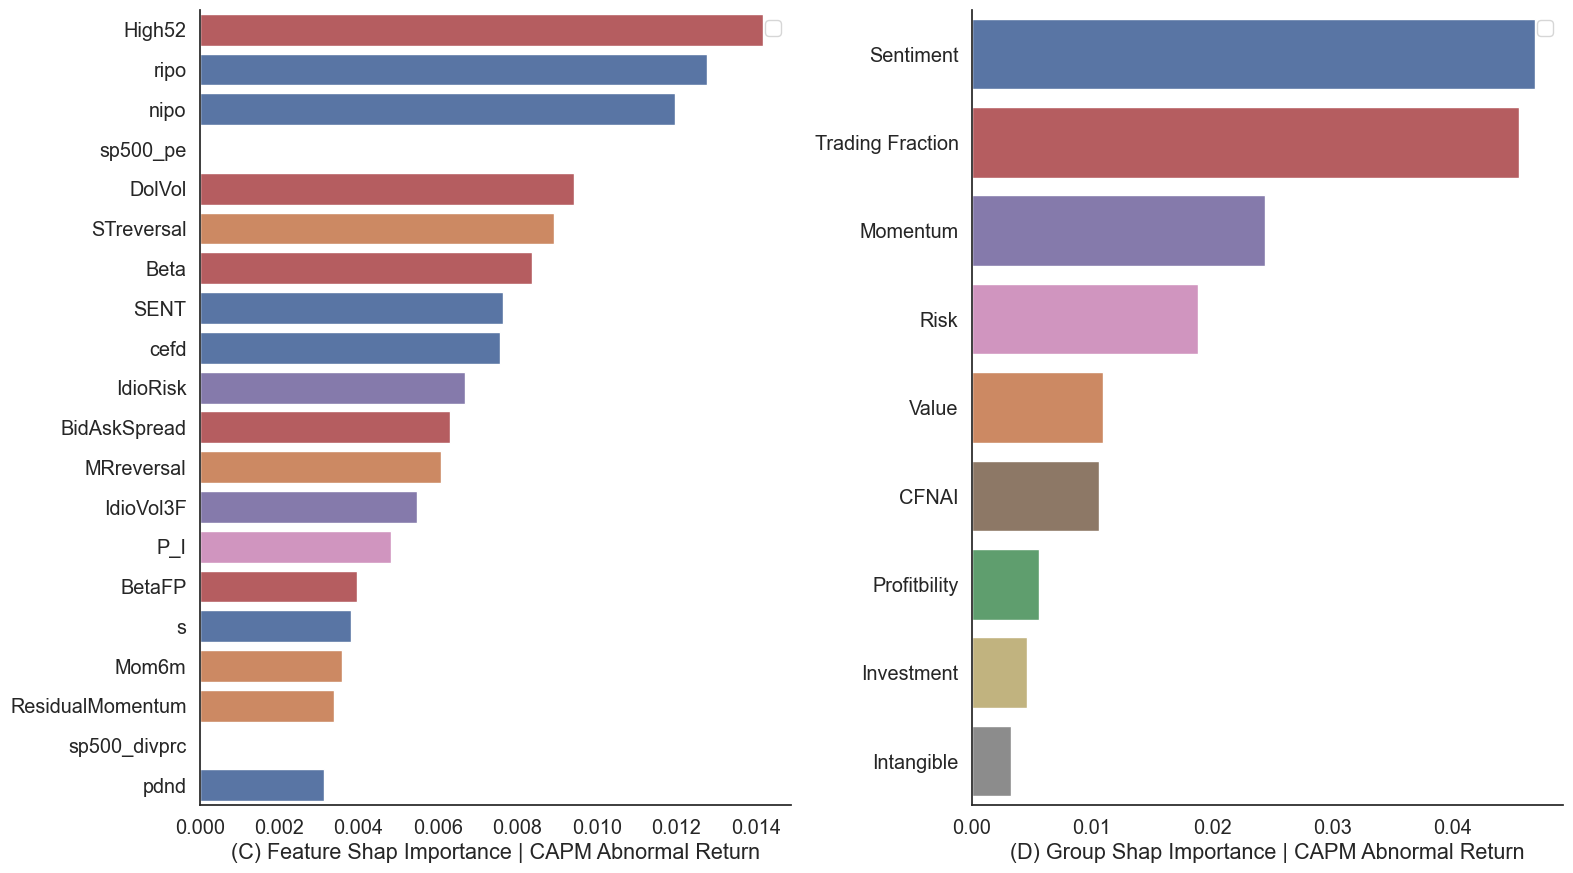

In [53]:
# plot feature importance
import seaborn as sns
from matplotlib import pyplot

sns.set_theme(font_scale=1.3, style='white')
fig, axes = pyplot.subplots(1,2,figsize=(16,9))

palette_1 = ['#c44e52', '#4c72b0', '#dd8452', '#8172b3', '#da8bc3', '#55a868', '#937860', '#ccb974', '#8c8c8c', ]
sns.barplot(data = importance_capm[0:20], x='shap_importance', y='column_name', hue='Group', dodge=False, ax=axes[0], palette=palette_1)
palette_2 = ['#4c72b0', '#c44e52', '#8172b3', '#da8bc3', '#dd8452', '#937860', '#55a868', '#ccb974', '#8c8c8c', ]
sns.barplot(x=group_capm[0:9], y=group_capm[0:9].index, orient='h', ax=axes[1], palette=palette_2)

for ax in axes:
  ax.set_ylabel('')
  ax.legend('')
axes[0].set_xlabel('(C) Feature Shap Importance | CAPM Abnormal Return')
axes[1].set_xlabel('(D) Group Shap Importance | CAPM Abnormal Return')
sns.despine(fig)

plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/feature_im2.png', dpi=300)

### 17.3 Features importance of predicting FF3 abnormal return

In [109]:
# Features importance of predicting stock abnormal return 
import shap
# print the JS visualization code to the notebook
shap.initjs()

# set seed for reproducibility
np.random.seed(42)

# randomly draw 100 observations to compute feature importance
background = X_train_scaled.iloc[np.random.choice(X_train_scaled.shape[0], 100, replace=False)][cols]
# based on which importance is checked
X_importance = X_test_scaled.iloc[np.random.choice(X_test_scaled.shape[0], 100, replace=False)][cols]

explainer_ff3 = [shap.KernelExplainer(model, background) for model in model_ff3_SENT]
shap_values_ff3 = [explain.shap_values(X_importance, nsamples=100) for explain in explainer_ff3]
shap_values_ff3 = np.array(shap_values_ff3)
# take average across ensemble members
shap_values_ff3 = np.mean(shap_values_ff3, axis=0)
clear_output()


In [110]:
# get shap feature importance
shap_ff3 = np.abs(shap_values_ff3)[0].mean(axis=0)
importance_ff3 = pd.DataFrame([cols, shap_ff3.tolist()]).T
importance_ff3.columns = ['column_name', 'shap_importance']
importance_ff3 = importance_ff3.sort_values('shap_importance', ascending=False)

# load variable group data
variable_group = pd.read_excel('data/raw_data/variable_group.xlsx')
importance_ff3 = importance_ff3.merge(variable_group, left_on='column_name', right_on='Variable', how='left')


In [111]:
# compute group importance
group_ff3 = importance_ff3.groupby('Group')['shap_importance'].sum()
group_ff3.sort_values(ascending=False, inplace=True)

The palette list has more values (9) than needed (8), which may not be intended.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



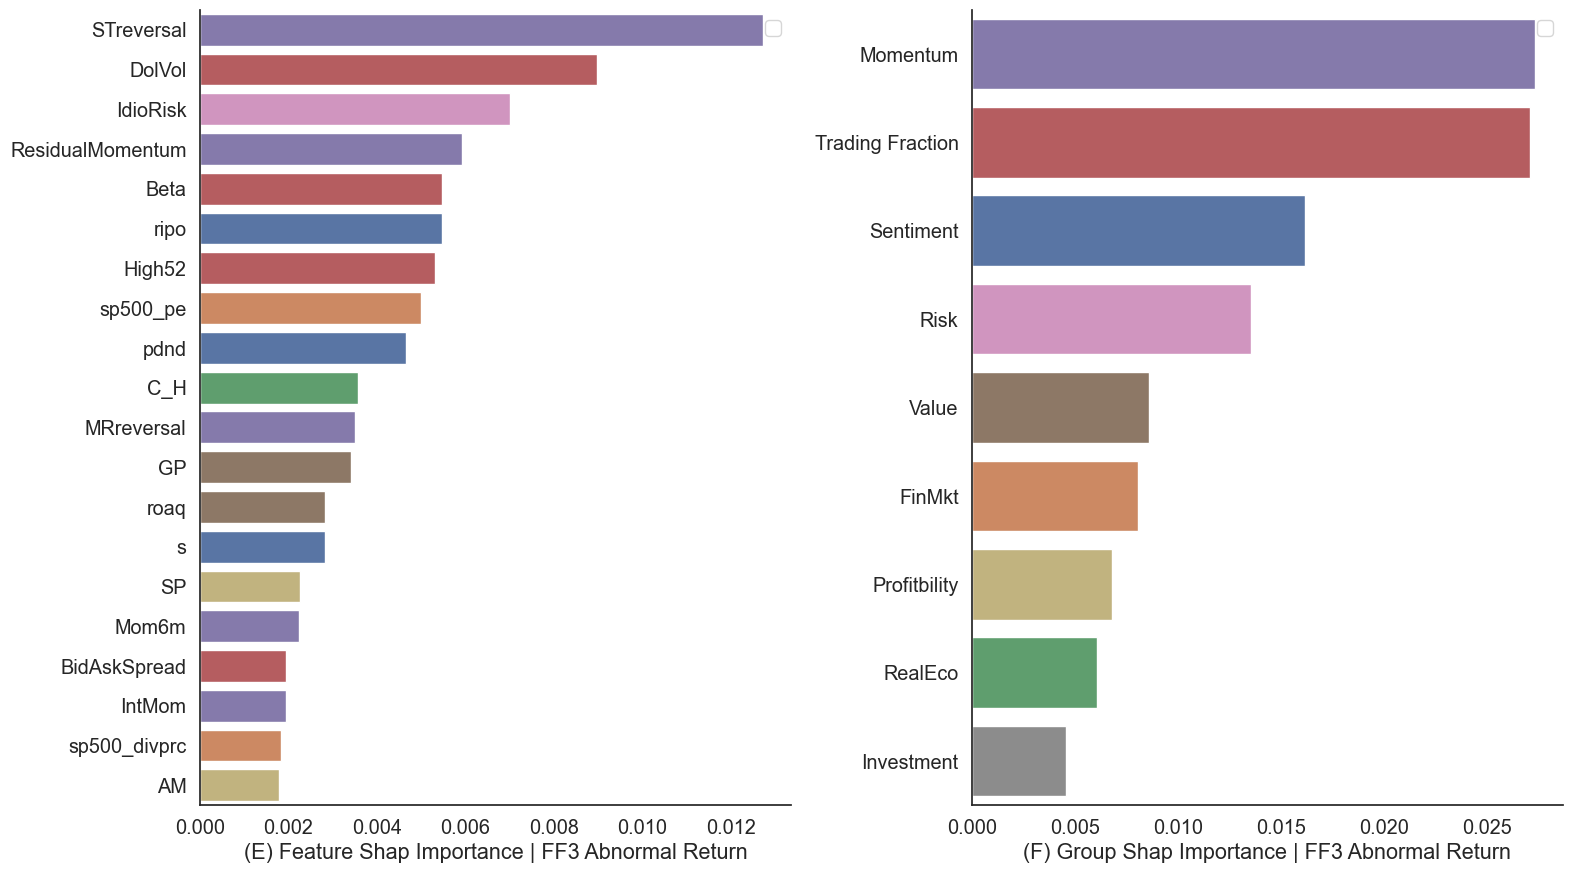

In [138]:
# plot feature importance
import seaborn as sns
from matplotlib import pyplot

sns.set_theme(font_scale=1.3, style='white')
fig, axes = pyplot.subplots(1,2,figsize=(16,9))

palette_1 = ['#8172b3', '#c44e52', '#da8bc3', '#4c72b0', '#dd8452', '#55a868', '#937860', '#ccb974', '#8c8c8c']
sns.barplot(data = importance_ff3[0:20], x='shap_importance', y='column_name', hue='Group', dodge=False, ax=axes[0], palette=palette_1)
palette_2 = ['#8172b3', '#c44e52', '#4c72b0', '#da8bc3', '#937860', '#dd8452', '#ccb974', '#55a868', '#8c8c8c']
sns.barplot(x=group_ff3[0:9], y=group_ff3[0:9].index, orient='h', ax=axes[1], palette=palette_2)

for ax in axes:
  ax.set_ylabel('')
  ax.legend('')
axes[0].set_xlabel('(E) Feature Shap Importance | FF3 Abnormal Return')
axes[1].set_xlabel('(F) Group Shap Importance | FF3 Abnormal Return')
sns.despine(fig)

plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/feature_im3.png', dpi=300)

### 17.4 Features importance of predicting FF5 abnormal return

In [113]:
# Features importance of predicting stock abnormal return 
import shap
# print the JS visualization code to the notebook
shap.initjs()

# set seed for reproducibility
np.random.seed(42)

# randomly draw 100 observations to compute feature importance
background = X_train_scaled.iloc[np.random.choice(X_train_scaled.shape[0], 100, replace=False)][cols]
# based on which importance is checked
X_importance = X_test_scaled.iloc[np.random.choice(X_test_scaled.shape[0], 100, replace=False)][cols]

explainer_ff5 = [shap.KernelExplainer(model, background) for model in model_ff5_SENT]
shap_values_ff5 = [explain.shap_values(X_importance, nsamples=100) for explain in explainer_ff5]
shap_values_ff5 = np.array(shap_values_ff5)
# take average across ensemble members
shap_values_ff5 = np.mean(shap_values_ff5, axis=0)
clear_output()


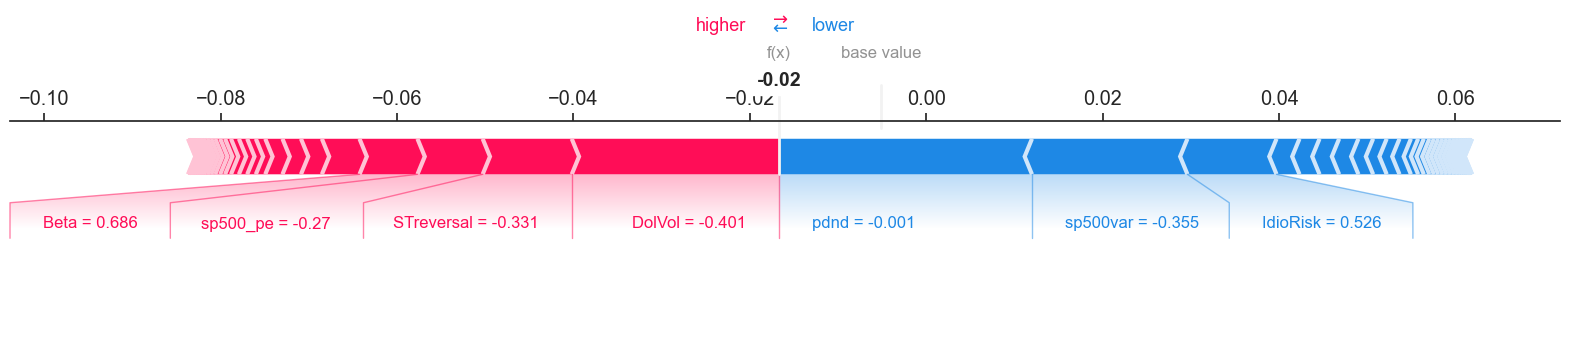

In [114]:
# plot the SHAP values for output of i
i = 20
shap.force_plot(np.array([explain.expected_value[0] for explain in explainer_ff5]).mean(), shap_values_ff5[0][i,:], np.round(X_test_scaled.iloc[i,:][cols],3), matplotlib=True, feature_names=cols)

In [115]:
# get shap feature importance
shap_ff5 = np.abs(shap_values_ff5)[0].mean(axis=0)
importance_ff5 = pd.DataFrame([cols, shap_ff5.tolist()]).T
importance_ff5.columns = ['column_name', 'shap_importance']
importance_ff5 = importance_ff5.sort_values('shap_importance', ascending=False)

# load variable group data
variable_group = pd.read_excel('data/raw_data/variable_group.xlsx')
importance_ff5 = importance_ff5.merge(variable_group, left_on='column_name', right_on='Variable', how='left')


In [116]:
# compute group importance
group_ff5 = importance_ff5.groupby('Group')['shap_importance'].sum()
group_ff5.sort_values(ascending=False, inplace=True)

The palette list has more values (9) than needed (8), which may not be intended.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



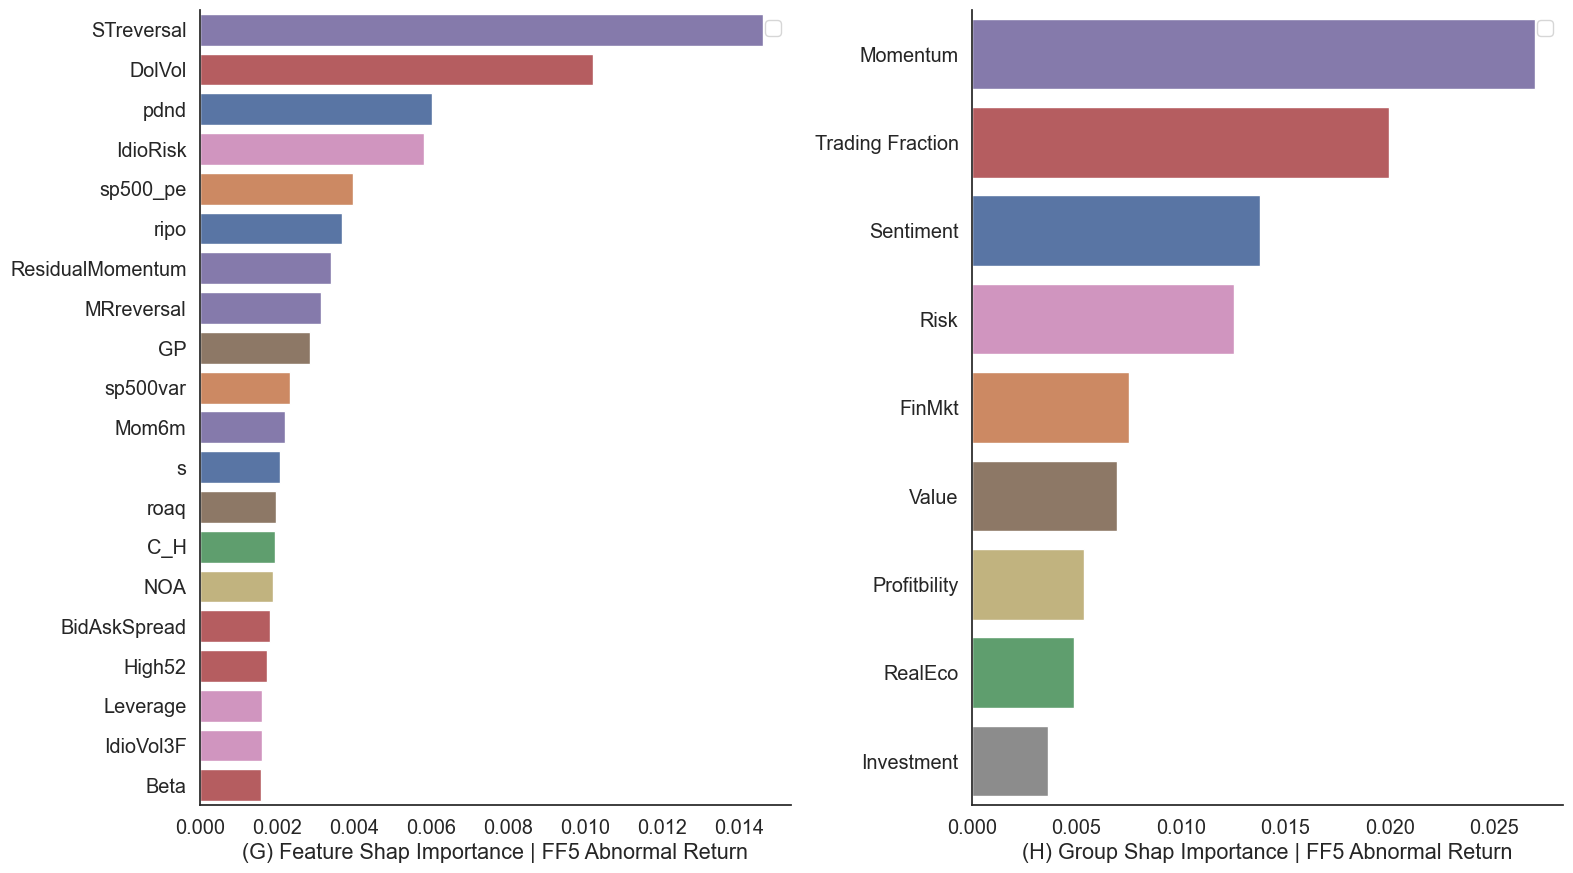

In [142]:
# plot feature importance
import seaborn as sns
from matplotlib import pyplot

sns.set_theme(font_scale=1.3, style='white')
fig, axes = pyplot.subplots(1,2,figsize=(16,9))

palette_1 = ['#8172b3', '#c44e52', '#4c72b0', '#da8bc3', '#dd8452', '#937860', '#55a868', '#ccb974', '#8c8c8c']
sns.barplot(data = importance_ff5[0:20], x='shap_importance', y='column_name', hue='Group', dodge=False, ax=axes[0], palette=palette_1)
palette_2 = ['#8172b3', '#c44e52', '#4c72b0', '#da8bc3', '#dd8452', '#937860', '#ccb974', '#55a868', '#8c8c8c']
sns.barplot(x=group_ff5[0:9], y=group_ff5[0:9].index, orient='h', ax=axes[1], palette=palette_2)

for ax in axes:
  ax.set_ylabel('')
  ax.legend('')
axes[0].set_xlabel('(G) Feature Shap Importance | FF5 Abnormal Return')
axes[1].set_xlabel('(H) Group Shap Importance | FF5 Abnormal Return')
sns.despine(fig)

plt.tight_layout()  # Adjust subplot layout for better spacing

# Specify high resolution (dpi) when saving the figure using Matplotlib's savefig
plt.savefig('graphics/feature_im4.png', dpi=300)

## 18. Interaction Effect
### 18.1 Interaction Effect with CFNAI

## 19. Marketing Time


In [17]:
# market timing based on CFNAI
# cut test data into tertiles
X_test_scaled['tertiles'] = pd.qcut(X_test_scaled['CFNAI'], 3, labels=False)
X_test['tertiles'] = pd.qcut(X_test['CFNAI'], 3, labels=False)

yhats_all = []
for model in [model_ex_SENT, model_capm_SENT, model_ff3_SENT, model_ff5_SENT]:
  yhats = []
  for i in range(0,3):
  # predict abnormal return in each tertiles
    yhat = ensemble_predict(model, X_test_scaled[X_test_scaled['tertiles']==i][cols])
    yhats.append(yhat)
  yhats_all.append(yhats)
clear_output()

In [19]:
portflios = list()
a = ['ex_return', 'ab_capm', 'ab_ff3', 'ab_ff5']
for r in range(0,4):
  portfolio = list()
  for i in range(0,3):
    tertiles = pd.DataFrame()
    # get the actual abnormal return from test dataset
    tertiles['actual_return'] = X_test[X_test['tertiles']==i][a[r]]
    tertiles['yhat'] = yhats_all[r][i]
    # cut predicted abnormal return into deciles
    tertiles['deciles'] = tertiles.groupby('year_month')['yhat'].transform(lambda g: pd.qcut(g, q=10, labels=list(f'Decile_{i}' for i in range(1,11))))
    # mean return and sharpe ratio in each deciles
    equal_weighted = tertiles.groupby(['deciles', 'year_month']).agg(mean_ret=pd.NamedAgg(column='actual_return', aggfunc='mean')).reset_index()
    # mean and sharpe ratio across all time in each deciles
    portf = pd.DataFrame(equal_weighted.groupby('deciles')['mean_ret'].mean())
    
    portf['std_ret'] = equal_weighted.groupby('deciles')['mean_ret'].std()
    portf['sharp'] = portf['mean_ret']/portf['std_ret']
    portf.drop('std_ret', axis=1, inplace=True)
    
    # long-short portfolios
    pf = pd.merge(equal_weighted[equal_weighted.deciles=='Decile_1'], equal_weighted[equal_weighted.deciles=='Decile_10'], on='year_month')
    pf['long_short'] = pf.mean_ret_y - pf.mean_ret_x
    pf_dic = pd.DataFrame({'mean_ret': [pf.long_short.mean()], 'sharp': [pf.long_short.mean()/pf.long_short.std()]})
    
    portf = pd.concat([portf, pf_dic], ignore_index=True)
    portfolio.append(portf)
  portflios.append(portfolio)

C:\Users\wangc\AppData\Local\Temp\ipykernel_8848\3900391951.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  equal_weighted = tertiles.groupby(['deciles', 'year_month']).agg(mean_ret=pd.NamedAgg(column='actual_return', aggfunc='mean')).reset_index()
C:\Users\wangc\AppData\Local\Temp\ipykernel_8848\3900391951.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portf = pd.DataFrame(equal_weighted.groupby('deciles')['mean_ret'].mean())
C:\Users\wangc\AppData\Local\Temp\ipykernel_8848\3900391951.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

In [27]:
pd.concat((p for p in portflios[0]), axis=1).round(3)

,mean_ret,sharp,mean_ret,sharp,mean_ret,sharp
0,-0.856,-0.108,-1.089,-0.180,-1.592,-0.228
1,-0.087,-0.013,0.006,0.001,-0.711,-0.121
2,0.422,0.064,0.099,0.021,-0.249,-0.044
3,0.503,0.080,0.524,0.119,0.232,0.042
4,0.845,0.130,0.822,0.198,0.263,0.049
5,1.408,0.195,0.705,0.157,0.635,0.110
6,1.403,0.199,1.126,0.235,0.829,0.140
7,1.771,0.234,1.297,0.261,0.970,0.152
8,2.134,0.238,1.474,0.247,1.504,0.210
9,4.398,0.323,2.476,0.313,2.879,0.311


In [28]:
pd.concat((p for p in portflios[1]), axis=1).round(3)

,mean_ret,sharp,mean_ret,sharp,mean_ret,sharp
0,-1.724,-0.352,-1.999,-0.427,-2.791,-0.558
1,-0.547,-0.169,-0.910,-0.277,-1.373,-0.379
2,-0.599,-0.218,-0.439,-0.155,-0.694,-0.242
3,-0.132,-0.046,-0.146,-0.057,-0.424,-0.135
4,-0.001,-0.001,0.208,0.098,-0.077,-0.028
5,0.232,0.059,0.299,0.122,0.292,0.086
6,0.704,0.182,0.513,0.187,0.228,0.060
7,0.955,0.190,0.719,0.255,0.541,0.140
8,1.209,0.210,0.946,0.250,0.801,0.175
9,3.076,0.299,1.615,0.285,1.947,0.272


In [29]:
pd.concat((p for p in portflios[2]), axis=1).round(3)

,mean_ret,sharp,mean_ret,sharp,mean_ret,sharp
0,-1.914,-0.402,-1.758,-0.454,-2.129,-0.540
1,-1.156,-0.331,-0.878,-0.328,-0.796,-0.301
2,-0.611,-0.261,-0.505,-0.270,-0.474,-0.220
3,-0.378,-0.152,-0.161,-0.104,-0.161,-0.071
4,-0.515,-0.270,0.006,0.004,-0.176,-0.089
5,0.012,0.005,0.072,0.044,-0.163,-0.086
6,0.151,0.061,0.352,0.194,-0.133,-0.073
7,0.474,0.150,0.278,0.129,0.316,0.138
8,1.062,0.222,0.803,0.309,0.569,0.210
9,3.038,0.375,1.512,0.305,1.897,0.362


In [30]:
pd.concat((p for p in portflios[3]), axis=1).round(3)

,mean_ret,sharp,mean_ret,sharp,mean_ret,sharp
0,-1.798,-0.349,-1.736,-0.415,-1.914,-0.469
1,-1.113,-0.340,-0.749,-0.339,-0.811,-0.351
2,-0.471,-0.173,-0.531,-0.294,-0.282,-0.120
3,-0.321,-0.121,-0.435,-0.215,-0.458,-0.186
4,-0.197,-0.079,0.061,0.037,-0.404,-0.186
5,-0.206,-0.065,-0.003,-0.002,-0.097,-0.047
6,0.302,0.110,0.354,0.195,0.084,0.041
7,0.594,0.176,0.692,0.268,0.274,0.117
8,1.094,0.231,1.247,0.383,1.004,0.273
9,3.243,0.401,2.051,0.366,2.154,0.406
